<a href="https://colab.research.google.com/github/smok313-zdr/FindMyOrder/blob/main/FindMyOrder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Tworzenie struktury katalogu baretki**

In [ ]:
# prompt: wygeneruj skrypt do stworzenia takiej samej struktury folderu baretki wraz z jego wszystkimi podfolderami, żebym nie musiał za każdym razem tworzyć tego ręcznie

import os

def create_directory_structure(root_dir):
  """Creates the directory structure for the 'baretki' dataset.

  Args:
    root_dir: The root directory where the structure will be created.
  """

  categories = ["Siły Zbrojne w Służbie Ojczyzny - brązowa", "Siły Zbrojne w Służbie Ojczyzny - srebrna", "Siły Zbrojne w Służbie Ojczyzny - złota",
                "Medal za długoletnią służbę - brązowa", "Medal za długoletnią służbę - srebrna", "Medal za długoletnią służbę - złota"]  # Dodaj inne kategorie, jeśli potrzebne

  for category in categories:
    category_path = os.path.join(root_dir, category)
    os.makedirs(category_path, exist_ok=True) # Utwórz folder kategorii jeśli nie istnieje

# Przykład użycia:
root_directory = "/content/baretki"  # Zmień na żądaną lokalizację
create_directory_structure(root_directory)

print(f"Struktura folderów została utworzona w: {root_directory}")


Struktura folderów została utworzona w: /content/baretki3


**2. Budowa modelu CNN**

Visible directories: ['/content/baretki3/Siły Zbrojne w Służbie Ojczyzny - brązowa', '/content/baretki3/Siły Zbrojne w Służbie Ojczyzny - srebrna', '/content/baretki3/Siły Zbrojne w Służbie Ojczyzny - złota']
Found 25 images belonging to 3 classes.
Found 6 images belonging to 3 classes.
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.2800 - loss: 1.1115 - val_accuracy: 0.3333 - val_loss: 1.0928
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step - accuracy: 0.4400 - loss: 1.0812 - val_accuracy: 0.3333 - val_loss: 1.1589
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.4400 - loss: 1.0476 - val_accuracy: 0.5000 - val_loss: 1.3433
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.5200 - loss: 0.9668 - val_accuracy: 0.3333 - val_loss: 1.5250
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.4800 - loss: 0.9934 - val_accuracy: 0.3333 - val_loss: 1.4693
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.6000 - loss: 0.9027 -

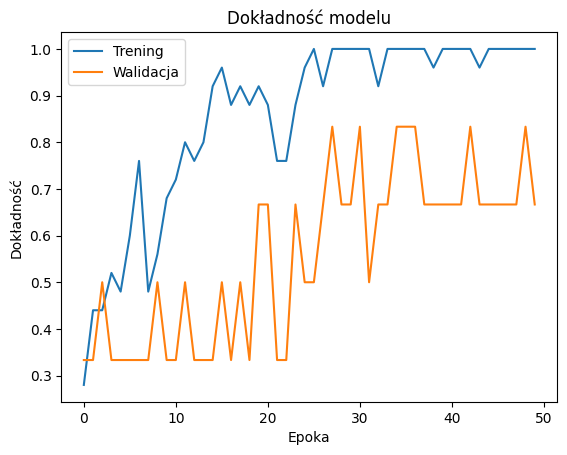

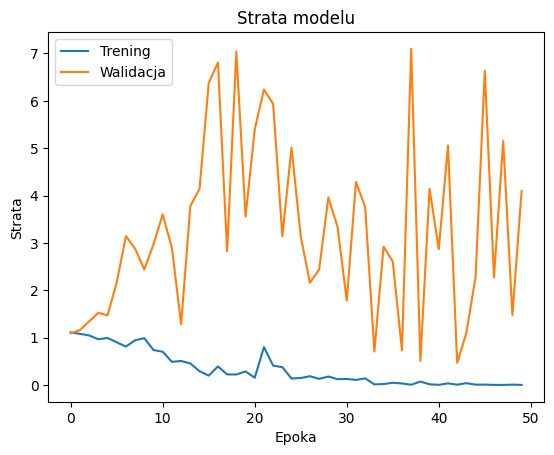

In [ ]:
# prompt: pomijaj ukryte domyślne foldery i pliki takie jak ".ipynb_checkpoints" w przeszukiwaniu folderów

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt

# Ścieżka do folderów z danymi
data_dir = "/content/baretki"  # Zmień na właściwą ścieżkę do folderu z danymi

# Parametry modelu
img_width, img_height = 150, 150
batch_size = 32
epochs = 50  # Zwiększ liczbę epok dla lepszej jakości predykcji

# Generatory danych
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% danych do walidacji
)

# Pomijanie ukrytych folderów i plików
def list_visible_directories(root_dir):
    visible_dirs = []
    for dirpath, dirnames, filenames in os.walk(root_dir):
      dirnames[:] = [d for d in dirnames if not d.startswith('.')] # Usuwa ukryte foldery
      visible_dirs.extend([os.path.join(dirpath, d) for d in dirnames])
    return visible_dirs


visible_dirs = list_visible_directories(data_dir)
print(f"Visible directories: {visible_dirs}")

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    classes = [d for d in os.listdir(data_dir) if not d.startswith('.')] # Pomijanie ukrytych folderów w klasach
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    classes = [d for d in os.listdir(data_dir) if not d.startswith('.')]  # Pomijanie ukrytych folderów w klasach
)

# Model CNN
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5), # Dodatkowa warstwa Dropout dla regularizacji
    keras.layers.Dense(3, activation='softmax')  # 3 klasy: brązowa, srebrna, złota
])

# Kompilacja modelu
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Trenowanie modelu
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


# Zapisz model
model.save('baretki_model.h5')

# (Opcjonalnie) Wyświetl wykresy dokładności i straty
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Dokładność modelu')
plt.ylabel('Dokładność')
plt.xlabel('Epoka')
plt.legend(['Trening', 'Walidacja'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Strata modelu')
plt.ylabel('Strata')
plt.xlabel('Epoka')
plt.legend(['Trening', 'Walidacja'], loc='upper left')
plt.show()


**3. Predykcja nowej baretki**

In [ ]:
# prompt: dokonaj predykcji, do jakiej klasy należy baretka "test3.png" z folderu content/baretki. Pokaż ile procent model wskazał na przypisanie baretki do danej klasy.

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import numpy as np

# Załaduj model
model = keras.models.load_model('baretki_model.h5')

# Ścieżka do obrazka
img_path = '/content/baretki/test2.png'

# Wczytaj i preprocessuj obrazek
img = image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0  # Normalizacja

# Dokonaj predykcji
predictions = model.predict(x)

# Pobierz nazwy klas
class_names = list(train_generator.class_indices.keys())

# Wyświetl wyniki
predicted_class_index = np.argmax(predictions[0])
predicted_class = class_names[predicted_class_index]
confidence = predictions[0][predicted_class_index] * 100

print(f"Przewidywana klasa: {predicted_class}")
print(f"Pewność: {confidence:.2f}%")

for i in range(len(class_names)):
  print(f"{class_names[i]}: {predictions[0][i] * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
Przewidywana klasa: Siły Zbrojne w Służbie Ojczyzny - brązowa
Pewność: 99.63%
Siły Zbrojne w Służbie Ojczyzny - brązowa: 99.63%
Siły Zbrojne w Służbie Ojczyzny - srebrna: 0.05%
Siły Zbrojne w Służbie Ojczyzny - złota: 0.33%
